In [1]:
from pathlib import Path
from tqdm.notebook import tqdm
from tabulate import tabulate
import random, json
import pycountry
from iso639 import languages
import networkx as nx
import pickle as pkl
from dateutil import parser
from datetime import datetime, timedelta
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import Counter
import Levenshtein
from wordcloud import STOPWORDS
from unidecode import unidecode
import unicodedata
from omnibelt import load_json, save_json
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

In [2]:
lang_clusters = {'en': ['au', 'ca', 'gb', 'ie', 'in', 'my', 'ng', 'nz', 'ph', 'sa', 'sg', 'us', 'za'],
				 'es': ['ar', 'co', 'cu', 'mx', 've'], 'de': ['at', 'ch', 'de'], 'fr': ['be', 'fr', 'ma'],
				 'zh': ['cn', 'hk', 'tw'], 'ar': ['ae', 'eg'], 'pt': ['br', 'pt'], 'bg': ['bg'], 'cs': ['cz'],
				 'el': ['gr'], 'he': ['il'], 'hu': ['hu'], 'id': ['id'], 'it': ['it'], 'ja': ['jp'], 'ko': ['kr'],
				 'lt': ['lt'], 'lv': ['lv'], 'nl': ['nl'], 'no': ['no'], 'pl': ['pl'], 'ro': ['ro'], 'ru': ['ru'],
				 'sv': ['se'], 'sl': ['si'], 'sk': ['sk'], 'sr': ['rs'], 'th': ['th'], 'tr': ['tr'], 'uk': ['ua']}
loc_names = {'gb': 'United Kingdom', 'ar': 'Argentina', 'pl': 'Poland', 'sk': 'Slovakia', 'us': 'United States',
			 'eg': 'Egypt', 'no': 'Norway', 'ph': 'Philippines', 'at': 'Austria', 'rs': 'Serbia', 'tw': 'Taiwan',
			 'be': 'Belgium', 'cu': 'Cuba', 'sa': 'Saudi Arabia', 'th': 'Thailand', 'id': 'Indonesia',
			 'ru': 'Russian Federation', 'ch': 'Switzerland', 'fr': 'France', 'lt': 'Lithuania', 'tr': 'Turkey',
			 'de': 'Germany', 'cz': 'Czechia', 'pt': 'Portugal', 'ae': 'United Arab Emirates', 'it': 'Italy',
			 'cn': 'China', 'lv': 'Latvia', 'nl': 'Netherlands', 'hk': 'Hong Kong', 'ca': 'Canada', 'br': 'Brazil',
			 'hu': 'Hungary', 'kr': 'Korea', 'si': 'Slovenia', 'au': 'Australia', 'my': 'Malaysia', 'ie': 'Ireland',
			 'ua': 'Ukraine', 'in': 'India', 'ma': 'Morocco', 'bg': 'Bulgaria', 'ng': 'Nigeria', 'il': 'Israel',
			 'se': 'Sweden', 'za': 'South Africa', 've': 'Venezuela', 'nz': 'New Zealand', 'jp': 'Japan',
			 'sg': 'Singapore', 'gr': 'Greece', 'mx': 'Mexico', 'co': 'Colombia', 'ro': 'Romania'}
lang_names = {'en': 'English', 'ko': 'Korean', 'ru': 'Russian', 'es': 'Spanish', 'pt': 'Portuguese', 'cs': 'Czech',
			  'tr': 'Turkish', 'nl': 'Dutch', 'ar': 'Arabic', 'fr': 'French', 'bg': 'Bulgarian', 'id': 'Indonesian',
			  'sk': 'Slovak', 'el': 'Greek', 'he': 'Hebrew', 'sr': 'Serbian', 'hu': 'Hungarian', 'th': 'Thai',
			  'zh': 'Chinese', 'no': 'Norwegian', 'sl': 'Slovenian', 'sv': 'Swedish', 'de': 'German', 'lv': 'Latvian',
			  'pl': 'Polish', 'it': 'Italian', 'ro': 'Romanian', 'lt': 'Lithuanian', 'ja': 'Japanese',
			  'uk': 'Ukrainian'}
cluster_id = {loc: lang for lang, locs in lang_clusters.items() for loc in locs}
len(cluster_id)

54

In [3]:
def show_date(date):
	return date.strftime('%d %b%y')
def get_locs(article):
	return [f'{loc_names[loc]}' for loc in sorted(set(i['location'] for i in article['instances']))]
def get_cats(article):
	return [f'<{cat}>' for cat in sorted(set(i['category'] for i in article['instances']))]
def view_article(art, detailed=False):
	cats = ' '.join(get_cats(art))
	locs = ', '.join(map(repr, get_locs(art)))
	published = parser.parse(art['publishedAt'])
	collected = [parser.parse(i['collectedAt']) for i in art['instances']]
	first = min(collected)
	last = max(collected)
	timing = f'{show_date(first)}' if first == last else f'{show_date(first)} - {show_date(last)}'

	lines = []
	if 'en-title' in art:
		lines.append(f'English Title: {art["en-title"]!r}')
	lines.append(f'{lang_names[art["language"]]} Title: {art["title"]!r}')
	lines.append(f'Categories: {cats}  ---   {locs} ({timing})  ---  {art["source-name"]}')

	if detailed:
		added_desc = False
		desc = art.get('description')
		en_desc = art.get('en-description')
		if en_desc is not None and len(en_desc):
			lines.append(f'English Description: {en_desc}')
			added_desc = True
		if desc is not None and len(desc):
			lines.append(f'{lang_names[art["language"]]} Description: {desc}')
			added_desc = True
		if not added_desc:
			lines.append(f'- No description -')
	print('\n'.join(lines))
def str_similarity(string1: str, string2: str):
	distance = Levenshtein.distance(string1, string2)
	similarity = 1 - (distance / max(len(string1), len(string2)))
	return similarity
def capsim(s1, s2):
	s1, s2 = unidecode(s1), unidecode(s2)
	return (str_similarity(s1.lower(), s2.lower()) + str_similarity(s1, s2)) / 2
def inst_id(art_id, inst_idx):
	return f'{str(art_id).zfill(7)}-{str(inst_idx).zfill(3)}'
def get_inst(inst_id):
	art_id, inst_idx = inst_id.split('-')
	art = by_ID[art_id]
	inst = art['instances'][int(inst_idx)]
	return {**inst, **art}
def art_row(art):
	return {'aid': art['ID'], 'title': art.get('en-title', art['title']), 'source': art['source-name'],
			'language': art['language']}
def get_title(art):
	return art.get('en-title', art['title'])
def article_title_bag(art):
	title = art.get('en-title', art['title'])
	title_doc = nlp(title)
	key_terms = Counter([token.lemma_.lower() for chunk in title_doc.noun_chunks for token in chunk])
	return key_terms
stop_words = set(STOPWORDS)
def is_good_word(w):
	return not all(unicodedata.category(char).startswith('P') or unicodedata.category(char).startswith('N') for char in w) and w not in stop_words

In [4]:
# root = Path('/home/fleeb/workspace/local_data/nnn')
root = Path(r'C:\Users\anwan\workspace\local_data\nnn')
recs = (root / 'old-bb-v1').glob('**/*.json')
recs = (root / 'babel-briefings-v1').glob('**/*.json')
temproot = root/'temp'
temproot.mkdir(exist_ok=True)
recs = list(recs)
len(recs)

54

In [6]:
# articles = []
# for rec in tqdm(recs):
# 	articles.extend(load_json(rec))
# by_ID = {}
# for article in tqdm(articles):
# 	by_ID[article['ID']] = article
# len(articles)

In [5]:
# use_bags_as_sets = True
# all_bags = load_json(temproot/'all_bags.json')
# # all_bags_inds = load_json(temproot/'all_bags_inds.json')
# all_bags = {int(ID): set(bag) if use_bags_as_sets else bag for ID, bag in all_bags.items()}

# relbags = {ID: list(all_bags[ID]) for ID in byID}
# save_json(relbags, temproot/'relbags.json')

# pkl.dump(date_aids, open(temproot/'date_aids.pkl', 'wb'))
date_aids = pkl.load(open(temproot/'date_aids.pkl', 'rb'))
daytfidf = pkl.load(open(temproot/'daytfidf.pkl', 'rb'))

In [6]:
numday = load_json(temproot/'numday.json')
full_time_graph = load_json(temproot/'top-clusters-full-signals.json')
centers = [int(i) for i in full_time_graph]
centers = np.array(centers)
sigs = [[len(sig) for sig in matches] for matches in full_time_graph.values()]
sigs = np.array(sigs)
sigs.shape

(2217, 413)

In [7]:
byID = {int(ID): data for ID, data in load_json(temproot/'best-articles.json').items()}
all_bags = {int(ID): bag for ID, bag in load_json(temproot/'relbags.json').items()}
for bag in all_bags.values():
	if '\'s' in bag:
		bag.remove('\'s')

In [8]:
clusters = {}
for center in tqdm(full_time_graph):
	cluster = set()
	for sig in full_time_graph[center]:
		cluster.update(sig)
	clusters[int(center)] = list(cluster)
len(clusters)

  0%|          | 0/2217 [00:00<?, ?it/s]

2217

In [9]:
mentions = Counter([aid for matches in full_time_graph.values() for aids in matches for aid in aids])
len(mentions)

381751

In [7]:
# articles = {}
# itr = tqdm(range(len(mentions)))
# for i, rec in enumerate(recs):
# 	if len(articles) >= len(mentions):
# 		break
# 	itr.set_description(f'{i+1}/{len(recs)} - {rec.stem}')
# 	for article in load_json(rec):
# 		if article['ID'] in mentions:
# 			articles[article['ID']] = article
# 			itr.update()
# len(articles)
# save_json(articles, temproot/'best-articles.json')

  0%|          | 0/381751 [00:00<?, ?it/s]

381751

In [5]:
cluster_bags = {cid: Counter([w for aid in clusters[cid] for w in all_bags[aid]]) for cid in clusters}
len(cluster_bags)

In [554]:
daydates = [datetime.strptime(d, '%Y-%m-%d') for d in sorted(numday.values())]
offsets = [(dat - daydates[0]).days for dat in daydates]
offset = np.array(offsets)
start_date = datetime(2020, 9, 1)
end_date = datetime(2021, 11, 1)
start_idx, end_idx = daydates.index(start_date), daydates.index(end_date)
offset -= offset[start_idx]
end_idx - start_idx

368

In [555]:
X = np.arange(0, offset[end_idx])
len(X)

426

In [556]:
masses = sigs[:,start_idx:end_idx].sum(axis=1)
maxmass = np.argsort(masses)[::-1]
top_idx = maxmass[:100]

inds = [ 
	# 3, 4, 
	0, 5, 6, 7, 10, 11, 12, 13, 23, 27]
# inds = list(range(10))
inds = [i for i in range(0,100) if i not in inds]
inds = list(range(100))

# top_idx = maxmass[[ 3, 4, 5, 6,7,8,9,10,11,12]]
top_idx = maxmass[inds]
top_centers = centers[top_idx]
top_sigs = sigs[top_idx]

print(tabulate([[str(aid), 
				 masses[i], 
				 byID[aid]['instances'][0]['collectedAt'].split('T')[0],
				 byID[aid].get('en-title', byID[aid]['title'])[:60], 
				 ', '.join(f'{w!r}:{c}' for w, c in cluster_bags[aid].most_common(5)),
				 ] for i, aid in zip(top_idx,top_centers)]))


-------  ----  ----------  ------------------------------------------------------------  --------------------------------------------------------------------------------
2372091  9791  2020-12-27  Iggy Azalea Tears Strips Off Playboi Carti For Skipping Thei  'christmas':9052, 'will':880, 'new':620, 'year':578, 'gift':542
4211607  6613  2021-04-17  [Coinbase] Coinbase’s listing stirred up Dogecoin, rising 40  'dogecoin':3342, 'coinbase':1857, 'bitcoin':990, 'musk':956, 'elon':705
4173893  5675  2021-04-15  Business Report: Concerns over blood clots impact J&J and As  'coinbase':1857, 'clot':1832, 'vaccine':1697, 'blood':1564, 'j&j':1078
4106626  5044  2021-04-11  Prince William cancels his participation today at the Bafta   'philip':4205, 'prince':3297, 'queen':928, 'funeral':686, 'elizabeth':602
1971973  4945  2020-11-28  Maradona has left the Casa Rosada: an incredible crowd escor  'maradona':4758, 'diego':1526, 'death':572, 'messi':311, 'tribute':289
6001705  4699  2021-08-18  Afghan

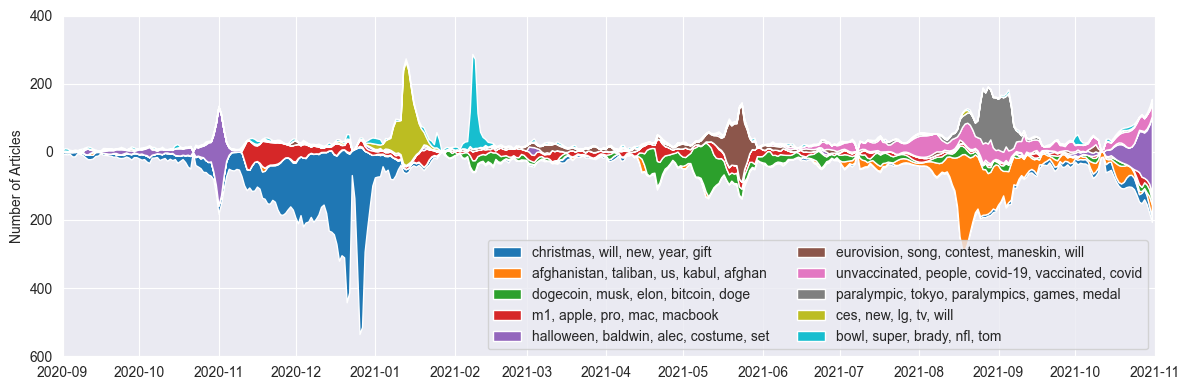

In [279]:
fg = plt.figure(figsize=(12,4))

Ys = []
for sig in top_sigs:
	interp_func = interp1d(offset, sig, kind='quadratic', fill_value="extrapolate")
	Ys.append(np.clip(interp_func(X),0,None))
Ys = np.array(Ys).T

cYs = Ys.cumsum(axis=1)

Y = cYs
# Y = Ys
dates = [start_date + timedelta(days=i.item()) for i in X]

labels = [ 
			 # str(i) + ' ' +
			 # byID[aid].get('en-title', byID[aid]['title'])[:60] 
			 ', '.join(f'{w}' for w, c in cluster_bags[aid].most_common(5))
			 # ', '.join(f'{w!r}:{c}' for w, c in cluster_bags[aid].most_common(5))
			 for i, aid in zip(inds, top_centers)]


# if len(top_idx) <= 10 or True:
# 	lines = plt.plot(dates, Y, lw=0)
# 
# else:
# 	lines = plt.plot(dates, Y, lw=0.5) 
# 
# lb = 0
# for i in range(Y.shape[1]):
# 	plt.fill_between(dates, lb, Y[:, i], alpha=1)
# 	lb = Y[:, i]

stack_baseline = 'sym'
stack_baseline = 'wiggle'
# stack_baseline = 'weighted_wiggle'

out = plt.stackplot(dates, Ys.T, ls='', labels=labels, alpha=1, baseline = stack_baseline);

patches = [mpatches.Patch(color=line.get_color(), label=label) for line, label in zip(lines, labels)]

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# Set the date range for the x-axis
plt.xlim(start_date, end_date)


# plt.legend(handles=lines + patches);
plt.legend(ncols=2, loc='lower right');
# plt.xlabel('Date');
plt.ylabel('Number of Articles');
# plt.yticks()
plt.yticks(plt.yticks()[0], [f'{abs(int(tick))}' for tick in plt.yticks()[0]])
# plt.yticks([])
# plt.ylim(0, 400);
# plt.xlim(0, 300);
# plt.plot(X, Ys, label=f'{center}');
plt.tight_layout();

In [275]:
fg.savefig(temproot/'top-articles.pdf', dpi=300);
fg.savefig(temproot/'top-articles.png', dpi=300);

In [349]:
daydates = [datetime.strptime(d, '%Y-%m-%d') for d in sorted(numday.values())]
offsets = [(dat - daydates[0]).days for dat in daydates]
offset = np.array(offsets)
start_date = datetime(2020, 10, 1)
end_date = datetime(2021, 10, 1)
# start_date = datetime(2021, 1, 15)
# end_date = datetime(2021, 3, 1)


317

In [576]:

start_date = datetime(2020, 10, 1)
end_date = datetime(2021, 10, 1)
clustercenter = 2372091

clustercenter, start_date, end_date = 2976484, datetime(2020, 12, 31), datetime(2021, 3, 14)
# clustercenter, start_date, end_date = 7069994, datetime(2020, 9, 1), datetime(2020, 12, 1)
# clustercenter, start_date, end_date = 6001705, datetime(2021, 7, 1), datetime(2021, 11, 1)
# clustercenter, start_date, end_date = 2906997, datetime(2021, 1, 15), datetime(2021, 3, 1)
# clustercenter, start_date, end_date = 1971973, datetime(2020, 11, 1), datetime(2021, 1, 2)
# clustercenter, start_date, end_date = 4969615, datetime(2021, 9, 1), datetime(2021, 11, 20)
# clustercenter, start_date, end_date = 4647262, datetime(2021, 4, 1), datetime(2021, 7, 1)
# clustercenter, start_date, end_date = 3963986, datetime(2020, 12, 1), datetime(2021, 4, 15)
# clustercenter, start_date, end_date = 4211607, datetime(2021, 4, 1), datetime(2021, 8, 14)
# clustercenter, start_date, end_date = 2372091, datetime(2020, 10, 1), datetime(2021, 2, 1)

start_idx, end_idx = daydates.index(start_date), daydates.index(end_date)
offset -= offset[start_idx]
end_idx - start_idx

cluster = clusters[clustercenter]
print(byID[clustercenter].get('en-title', byID[clustercenter]['title']))
print(', '.join(f'{w!r}:{c}' for w, c in cluster_bags[clustercenter].most_common(5)))
len(cluster)

Watch: Timothee Chalamet stars with Winona Ryder as Edward Scissorhands' son in Super Bowl ad - Stuff.co.nz
'bowl':1999, 'super':1266, 'brady':189, 'nfl':145, 'tom':141


2021

In [577]:
X = np.arange(0, offset[end_idx])
Ys = []
for sig in top_sigs:
	interp_func = interp1d(offset, sig, kind='quadratic', fill_value="extrapolate")
	Ys.append(np.clip(interp_func(X),0,None))
Ys = np.array(Ys).T
len(X)

73

In [578]:
lang_number = {
	'en': 1128233, 'es': 455952, 'fr': 288328, 'zh': 270887, 'de': 259718, 'pt': 243829, 'ar': 178854, 'id': 131252,
	'it': 129005, 'tr': 122724, 'el': 119940, 'ja': 118475, 'pl': 116904, 'ru': 113395, 'nl': 104031, 'th': 90708,
	'sv': 86838, 'ko': 83090, 'sr': 80040, 'hu': 73509, 'cs': 70647, 'he': 67794, 'bg': 67223, 'uk': 65610, 'ro': 54601,
	'no': 46804, 'sk': 43057, 'lv': 40006, 'lt': 34719, 'sl': 33026
}

In [579]:
aid_sigs = full_time_graph[str(clustercenter)]
key = 'language'
stats = [Counter(byID[aid][key] for aid in aids) for aids in aid_sigs]
len(stats)

413

In [580]:
import seaborn as sns
import colorcet as cc

lang_colors = {l: cc.cm.glasbey_category10.colors[i] for i, l in enumerate(lang_number)}

In [581]:
key_cols = ['en', 'es', 'fr', 'zh', 'de', 'pt', 'ar', 'id']
key_cols = list(lang_number.keys())
total = sum(lang_number[col] for col in lang_number)
lang_wts = {l: total / lang_number[l] for l in lang_number}
lang_wts = {l: lang_wts[l] / sum(lang_wts.values()) for l in lang_wts}
lang_wts = {}
include_other = len(key_cols) < len(lang_number) and True

stat_sigs = []
for stat in stats:
	row = [lang_wts.get(col, 1.) * stat.get(col, 0.) for col in key_cols]
	if include_other:
		row.append(sum(stat[col] for col in stat if col not in key_cols))
	stat_sigs.append(row)

stat_sigs = np.array(stat_sigs).T

# sort stat sigs
sort_idx = np.argsort(stat_sigs.sum(axis=1))[::-1]
stat_sigs = stat_sigs[sort_idx][:10]
key_cols = np.array(key_cols)[sort_idx].tolist()[:10]
empty = stat_sigs.sum(axis=1) == 0
key_cols = np.array(key_cols)[~empty].tolist()
stat_sigs = stat_sigs[~empty]
num_stats = stat_sigs.sum(axis=1)
stat_sigs.shape

(10, 413)

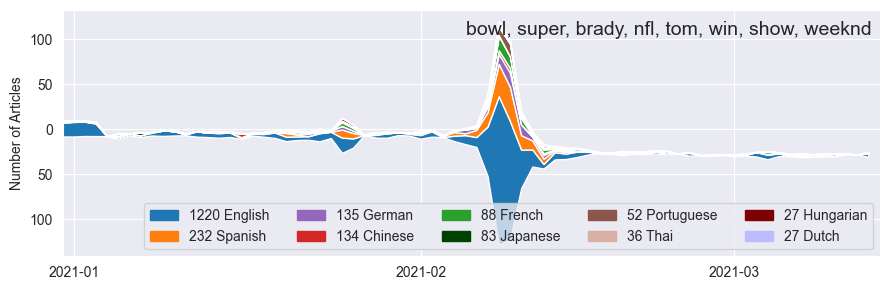

In [583]:
fg = plt.figure(figsize=(9,3))

labels = [*key_cols] + (['other'] if include_other else [])

dates = [start_date + timedelta(days=i.item()) for i in X]

Ys = []
for sig in stat_sigs:
	interp_func = interp1d(offset, sig, kind='quadratic', fill_value="extrapolate")
	Ys.append(np.clip(interp_func(X),0,None))
Ys = np.array(Ys).T
cYs = Ys.cumsum(axis=1)
Y = cYs
# Y = Ys

# if len(top_idx) <= 10 or True:
# 	lines = plt.plot(dates, Y, lw=0)
# 
# else:
# 	lines = plt.plot(dates, Y, lw=0.5) 
# 
# lb = 0
# for i in range(Y.shape[1]):
# 	plt.fill_between(dates, lb, Y[:, i], alpha=.3)
# 	lb = Y[:, i]

out = plt.stackplot(dates, Ys.T, ls='', alpha=1, baseline = 'weighted_wiggle', colors=[lang_colors[l] for l in labels]);

patches = [mpatches.Patch(color=lang_colors[label], label=
							# lang_names[label]
						  f'{int(num)} {lang_names[label]}'
						  ) 
		   for c, label, num in zip(cc.cm.glasbey_category10.colors, key_cols, num_stats)]

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# Set the date range for the x-axis
plt.xlim(start_date, end_date)


# plt.legend(handles=lines + patches);
plt.legend(handles=patches, ncols=5, loc='lower right');
# plt.xlabel('Date');
plt.ylabel('Number of Articles');
# plt.yticks()
plt.yticks(plt.yticks()[0][1:-1], [f'{abs(int(tick))}' for tick in plt.yticks()[0]][1:-1])

plt.text(0.99, 0.9, ', '.join(f'{w}' for w, c in cluster_bags[clustercenter].most_common(8)),
		 horizontalalignment='right',
		 # verticalalignment='center',
		 transform=plt.gca().transAxes,
		 fontsize=14,
		 # bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
		 )

plt.tight_layout();

# plt.imshow(Ys, aspect='auto', cmap='viridis');


In [584]:
fg.savefig(temproot/f'event-{clustercenter}.pdf', dpi=300);
fg.savefig(temproot/f'event-{clustercenter}.png', dpi=300);

C:\Users\anwan\AppData\Local\Temp\ipykernel_2784\1778417726.py:37: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(handles=lines + patches);


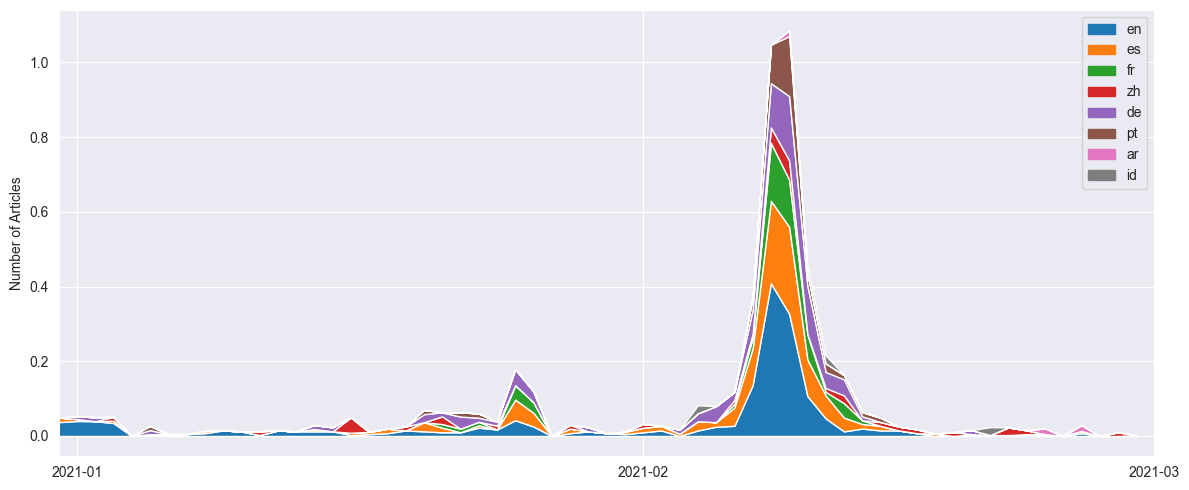

In [229]:
fg = plt.figure(figsize=(12,5))

Ys = []
for sig in stat_sigs:
	interp_func = interp1d(offset, sig, kind='quadratic', fill_value="extrapolate")
	Ys.append(np.clip(interp_func(X),0,None))
Ys = np.array(Ys).T

cYs = Ys.cumsum(axis=1)

Y = cYs
# Y = Ys
dates = [start_date + timedelta(days=i.item()) for i in X]

labels = [*key_cols] + (['other'] if include_other else [])


if len(top_idx) <= 10 or True:
	lines = plt.plot(dates, Y, lw=0)

else:
	lines = plt.plot(dates, Y, lw=0.5) 

lb = 0
for i in range(Y.shape[1]):
	plt.fill_between(dates, lb, Y[:, i], alpha=1)
	lb = Y[:, i]

patches = [mpatches.Patch(color=line.get_color(), label=label) for line, label in zip(lines, labels)]

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# Set the date range for the x-axis
plt.xlim(start_date, end_date)


plt.legend(handles=lines + patches);
# plt.legend();
# plt.xlabel('Date');
plt.ylabel('Number of Articles');
# plt.ylim(0, 400);
# plt.xlim(0, 300);
# plt.plot(X, Ys, label=f'{center}');
plt.tight_layout();

In [619]:
random.choice(list(a for a in byID.values() if a['language'] == 'de'))

{'author': 'Bunte.de Redaktion',
 'title': 'Carl Philip & Sofia von Schweden: Hoppla! Haben sie vergessen, diesem Familienmitglied von Julians Geburt zu berichten? - BUNTE.de',
 'description': 'Prinz Carl Philip und Prinzessin Sofia von Schweden sind zum dritten Mal Eltern geworden. Doch ein Familienmitglied wusste nichts von den freudigen Baby-News. Alle Infos im royalen Ticker auf BUNTE.de.',
 'url': 'https://www.bunte.de/royals/schwedisches-koenigshaus/carl-philip-sofia-von-schweden-hoppla-haben-sie-vergessen-diesem-familienmitglied-von-julians-geburt.html',
 'urlToImage': 'https://images.bstatic.de/d12FaX7n17t-Q45C2f8qyTXkxsE=/1200x630/filters:focal(1527x855:1547x875)/files/2021-03/carl-sofia-gettyimages-1230063157.jpg',
 'publishedAt': '2021-03-30T15:40:31Z',
 'content': 'Prinz Carl Philip und Prinzessin Sofia von Schweden sind zum dritten Mal Eltern geworden. Doch ein Familienmitglied wusste nichts von den freudigen Baby-News. Alle Infos im royalen Ticker auf BUNTE.d… [+25633 cha

In [ ]:
{'author': 'Etienne Froment pour 20 Minutes',
 'title': 'Microsoft a décidé de faire une croix sur Cortana, Skype ou encore OneNote pour Windows 11 - 20 Minutes',
 'description': 'La firme de Richmond a décidé de faire le grand ménage pour son futur système d’exploitation',
 'url': 'https://www.20minutes.fr/high-tech/3073731-20210629-windows-11-tout-ce-qui-va-disparaitre-du-systeme-d-exploitation',
 'urlToImage': 'https://img.20mn.fr/kKVBtoBVQ0qSJHJZozJ3ryk/648x360_windows-11-tout-ce-qui-va-disparaitre-du-systeme-d-exploitation.jpg',
 'publishedAt': '2021-07-04T12:50:19Z',
 'content': 'La nouvelle version de Windows présentée jeudi soir par Microsoft promet de nombreux changements. Le géant de linformatique na pas hésité à revoir complètement sa position sur toute une série de suje… [+3043 chars]',
 'instances': [{'collectedAt': '2021-07-05T09:28:00Z',
   'location': 'fr',
   'category': 'technology'},
  {'collectedAt': '2021-07-06T14:07:00Z',
   'location': 'fr',
   'category': 'technology'}],
 'source-id': None,
 'source-name': '20 Minutes',
 'ID': 5490303,
 'en-title': 'Microsoft has decided to give up on Cortana, Skype or even OneNote for Windows 11 - 20 Minutes',
 'en-description': 'The Richmond firm has decided to clean up its future operating system',
 'en-content': 'The new version of Windows presented Thursday evening by Microsoft promises many changes. The IT giant did not hesitate to completely review its position on a whole series of issues… [+3043 tanks]',
 'language': 'fr'}

{'author': 'DER SPIEGEL',
 'title': 'Ungewöhnlicher Geburtstagsgruß: Künstler benennt U-Bahn-Station nach Meryl Streep - DER SPIEGEL',
 'description': 'Gerade ist Schauspielikone Meryl Streep 72 geworden. Und hat jetzt ungeahnte Streep-Credibility verliehen bekommen.',
 'url': 'https://www.spiegel.de/panorama/new-york-kuenstler-benennt-u-bahn-station-nach-meryl-streep-a-f1506fd9-8af8-4162-b0b1-bb078908a3ea',
 'urlToImage': 'https://cdn.prod.www.spiegel.de/images/7d65c8b4-0001-0004-0000-000000008789_w1280_r1.77_fpx53_fpy44.jpg',
 'publishedAt': '2021-06-23T07:15:46Z',
 'content': 'Zu ihrem 72. Geburtstag ist Hollywood-Schauspielerin Meryl Streep mit einem ungewöhnlichen Geschenk überrascht worden: Street-Art-Künstler Adrian Wilson benannte die New Yorker U-Bahn-Station 72 Stre… [+841 chars]',
 'instances': [{'collectedAt': '2021-06-23T10:06:00Z',
   'location': 'de',
   'category': 'entertainment'}],
 'source-id': 'spiegel-online',
 'source-name': 'Spiegel Online',
 'ID': 5318423,
 'en-title': 'Unusual birthday greeting: Artist names subway station after Meryl Streep - DER SPIEGEL',
 'en-description': 'Acting icon Meryl Streep just turned 72. And has now been given unexpected Streep credibility.',
 'en-content': 'For her 72nd birthday, Hollywood actress Meryl Streep was surprised with an unusual gift: Street artist Adrian Wilson named the New York subway station 72 Street… [+841 chars]',
 'language': 'de'}

In [ ]:

clid = 2372091#6001705
neighbors = clusters[clid]
view_article(byID[clid])
print()
print(all_bags[clid])
print(len(neighbors))
# print()

In [3]:
sel = random.choices(neighbors, k=100)
count = Counter({w: 0 for w in all_bags[clid]})
for aid in sel:
	count.update([w for w in all_bags[aid] if w in count])
print(', '.join(f'{w!r}:{c}' for w, c in count.most_common(20)))
print(tabulate([[str(aid), 
				 len(byID[aid]['instances']), 
				 byID[aid]['instances'][0]['collectedAt'].split('T')[0], 
				 byID[aid]['language'], 
				 byID[aid].get('en-title', byID[aid]['title'])[:140]
] for aid in sel]))